In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

# 配置搜索路径
sys.path.append("./")
sys.path.append("../")
sys.path.append("../../")
import backtrader as bt
import pandas as pd
import pprint
import sqlite3
from tqdm import tqdm
from datetime import datetime
from strategies import CustomMLStrategy, MovingAverageCrossStrategy
from backtest_utils import CustomCommissionSchema, CustomAnalyzer
from Share.database.downloader.downloader_base import DownloaderBase
import Share.database.database_config as db_config

In [2]:
model_pred_list = []
pred_dir = './backtest_data/'
for file_name in sorted(os.listdir(pred_dir)):
    print(file_name)
    model_pred_list.append(pd.read_pickle(pred_dir+f'{file_name}'))
model_pred_df = pd.concat(model_pred_list)
# model_pred_df['stock_code'] = model_pred_df['stock_code'].map(lambda x: str(x).zfill(6))

stock_selection_results_20200101.pkl
stock_selection_results_20200701.pkl
stock_selection_results_20210101.pkl
stock_selection_results_20210701.pkl
stock_selection_results_20220101.pkl
stock_selection_results_20220701.pkl
stock_selection_results_20230101.pkl
stock_selection_results_20230701.pkl


In [3]:
BACKTEST_INITIAL_CASH = 1000000  # 初始化资金
BACKTEST_INDEX_SYMBOLS = "000016"  # 【选股】策略的对比基准=指数index，【择时】策略的对比基准=单股自身
# 构建数据里表
BACKTEST_STOCK_SYMBOLS = model_pred_df['stock_code'].unique().tolist()
BACKTEST_START_DATE = datetime.strptime(model_pred_df['datetime'].min(), "%Y-%m-%d").strftime("%Y%m%d")  # 回测开始日期
BACKTEST_END_DATE = datetime.strptime(model_pred_df['datetime'].max(), "%Y-%m-%d").strftime("%Y%m%d")  # 回测结束日期
print(f'Start: {BACKTEST_START_DATE}, End: {BACKTEST_END_DATE}')
BACKTEST_DATETIME_INDEX = pd.date_range(start=BACKTEST_START_DATE, end=BACKTEST_END_DATE, freq='B')

Start: 20200102, End: 20231222


In [4]:
# 初始化db_downloader
db_conn = sqlite3.connect("../../Share/database/hh_quant.db")
db_downloader = DownloaderBase(db_conn=db_conn, db_config=db_config)

In [5]:
cerebro = bt.Cerebro()

In [6]:
print("开始设置回测基础参数...")
cerebro.broker.setcash(BACKTEST_INITIAL_CASH)  # 配置初始资金量
cerebro.broker.addcommissioninfo(CustomCommissionSchema())  # 配置自定义的佣金类型

开始设置回测基础参数...


In [7]:
print("开始添加回测股票数据...")
for stock_symbol in tqdm(BACKTEST_STOCK_SYMBOLS):
    stock_data = db_downloader._download_stock_history_info(stock_symbol, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
    if not stock_data.empty:
        stock_data = stock_data[["datetime", "open", "high", "low", "close", "volume"]]
        stock_data["datetime"] = pd.to_datetime(stock_data["datetime"])
        stock_data = stock_data.set_index("datetime").reindex(BACKTEST_DATETIME_INDEX).fillna(method='bfill').fillna(method='ffill')
        stock_data_feeds = bt.feeds.PandasData(dataname=stock_data)  # 构建回测数据Feeds流
        cerebro.adddata(stock_data_feeds, name=stock_symbol)  # 添加回测数据

开始添加回测股票数据...


100%|██████████| 50/50 [00:00<00:00, 347.00it/s]


In [8]:
print("开始添加基准数据...")
benchmark_data = db_downloader._download_index_history_info(BACKTEST_INDEX_SYMBOLS, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
benchmark_data = benchmark_data[["datetime", "open", "high", "low", "close", "volume"]]
benchmark_data["datetime"] = pd.to_datetime(benchmark_data["datetime"])
benchmark_data = benchmark_data.set_index("datetime").reindex(BACKTEST_DATETIME_INDEX).fillna(method='bfill').fillna(method='ffill')
benchmark_name = f"benchmark_{BACKTEST_INDEX_SYMBOLS}"
benchmark_data_feeds = bt.feeds.PandasData(dataname=benchmark_data)  # 构建基准数据Feeds流
cerebro.adddata(benchmark_data_feeds, name=benchmark_name)  # 添加基准数据

开始添加基准数据...


In [9]:
print("开始添加策略...")
test_base = False

if test_base:
    strategy_params = {
        "benchmark": benchmark_name,
    }
    cerebro.addstrategy(MovingAverageCrossStrategy, **strategy_params)
else:
    strategy_params = {
            "top_n": 5,
            "take_profit_min_threshold": 0.0,
            "stop_loss_max_threshold": 0.0,
            "model_pred_dataframe": model_pred_df,
            "benchmark": benchmark_name,
            "risk_manage": True,
            "atr_period": 7,
            "atr_take_profit_multiplier":2 ,  # 2 * ATR作为止盈上限
            "atr_stop_loss_multiplier": 1,  # 1 * ATR作为止损下限
            "atr_risk_percent": 0.01,  # 风险0.01表示每次交易最多风险账户的1%
        }
    cerebro.addstrategy(CustomMLStrategy, **strategy_params)

开始添加策略...


In [10]:
print("开始添加分析器...")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")  # 添加最大回撤的分析器，后续customAnalyzer中需要用到
cerebro.addanalyzer(CustomAnalyzer, _name="custom_analyzer")  # 添加自定义的分析器

开始添加分析器...


In [11]:
# print("开始添加观察器...")
# cerebro.addobserver(bt.observers.Benchmark, data=benchmark_data_feeds, timeframe=bt.TimeFrame.NoTimeFrame)  # 添加基准对比观察器

In [12]:
print("开始运行回测...")
# 运行回测
results = cerebro.run()
# 打印初始资金
print(f"Start Portfolio Value: {BACKTEST_INITIAL_CASH}")
# 打印最终资金
print(f"Final Portfolio Value: {cerebro.broker.getvalue()}")

开始运行回测...
启动基准对比...
回测数据共: 50
开始计算ATR相关指标
2020-01-14 订单取消/保证金不足/拒绝
2020-01-14 订单取消/保证金不足/拒绝
2020-01-14 订单取消/保证金不足/拒绝
2020-01-14 买入执行, 引用: 1, 价格: 164.30, 成本: 429646.59, 手续费: 5.00, 数量: 2615.00, 股票: 600111
2020-01-14 买入执行, 引用: 2, 价格: 591.77, 成本: 469868.71, 手续费: 5.00, 数量: 794.00, 股票: 600436
2020-01-15 订单取消/保证金不足/拒绝
2020-01-15 订单取消/保证金不足/拒绝
2020-01-15 订单取消/保证金不足/拒绝
2020-01-15 买入执行, 引用: 6, 价格: 7.57, 成本: 46232.55, 手续费: 5.00, 数量: 6105.00, 股票: 600050
2020-01-15 买入执行, 引用: 7, 价格: 489.85, 成本: 42617.12, 手续费: 5.00, 数量: 87.00, 股票: 600406
2020-01-16 订单取消/保证金不足/拒绝
2020-01-16 订单取消/保证金不足/拒绝
2020-01-16 订单取消/保证金不足/拒绝
2020-01-16 订单取消/保证金不足/拒绝
2020-01-16 订单取消/保证金不足/拒绝
2020-01-16 ATR 触发止损... 执行平仓【股票: 600050】, 购入价格: 7.5729, 止损价格: 7.404146855476885】
2020-01-16 ATR 触发止损... 执行平仓【股票: 600406】, 购入价格: 489.852, 止损价格: 476.6300815077051】
2020-01-16 ATR 触发止损... 执行平仓【股票: 600111】, 购入价格: 164.3008, 止损价格: 160.52797409412744】
2020-01-17 订单取消/保证金不足/拒绝
2020-01-17 订单取消/保证金不足/拒绝
2020-01-17 卖出执行, 引用: 18, 价格: 7.36, 成本: 46232.55, 手续费

开始打印回测相关指标...
Start Portfolio Value: 1000000
Final Portfolio Value: 1460864.6578475533
{'其他': {'亏损次数': 1233,
        '夏普比率': 0.6153,
        '日均超额收益': 0.0007,
        '日胜率': 0.4759,
        '最大回撤': 18.2662,
        '最大回撤区间': 169,
        '盈亏比': 1.8556,
        '盈利次数': 769,
        '索提诺比率': 0.8724,
        '胜率': 0.3841,
        '贝塔': 0.7108,
        '超额收益': 0.7263,
        '超额收益夏普比率': 1.3092,
        '阿尔法': 0.0006},
 '基准': {'基准年化收益': -0.0722, '基准收益': -0.2654, '基准波动率': 0.1862},
 '策略': {'策略年化收益': 0.0965, '策略收益': 0.4609, '策略波动率': 0.1747}}


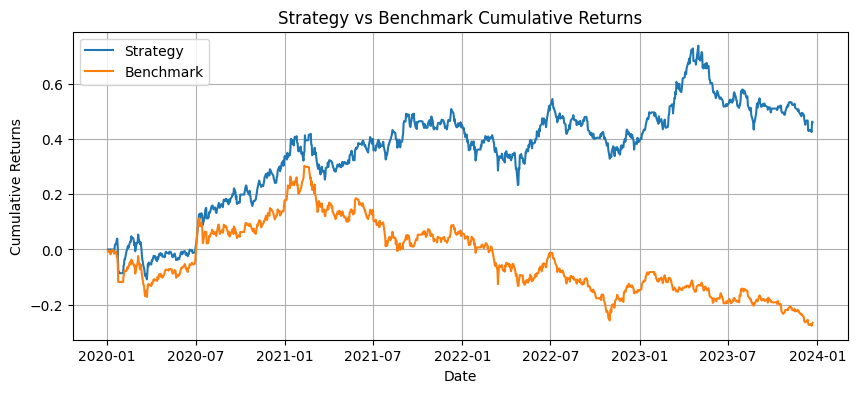

In [13]:
print("开始打印回测相关指标...")
# 打印初始资金
print(f"Start Portfolio Value: {BACKTEST_INITIAL_CASH}")
# 打印最终资金
print(f"Final Portfolio Value: {cerebro.broker.getvalue()}")

def plot_strategy_benchmark_returns(strategy_returns, benchmark_returns):
    import matplotlib.pyplot as plt
    # 检查index是否一致以保证对齐
    if not strategy_returns.index.equals(benchmark_returns.index):
        raise ValueError("Indexes of strategy_returns and benchmark_returns must match")
    # 计算累积收益率
    strategy_cumulative_returns = (1 + strategy_returns).cumprod() - 1
    benchmark_cumulative_returns = (1 + benchmark_returns).cumprod() - 1
    # 绘制累积收益率曲线
    plt.figure(figsize=(10,4))
    plt.plot(strategy_cumulative_returns, label='Strategy')
    plt.plot(benchmark_cumulative_returns, label='Benchmark')
    # 添加标题和标签
    plt.title('Strategy vs Benchmark Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    # 显示图例
    plt.legend()
    # 显示网格
    plt.grid(True)
    # 显示绘制的图形
    plt.show()

custom_analysis = results[0].analyzers.custom_analyzer.get_analysis()
format_analysis_result = {"基准": {}, "策略": {}, "其他": {}}
for key, value in custom_analysis.items():
    if key.startswith("基准"):
        format_analysis_result["基准"][key] = round(value, 4)
    elif key.startswith("策略"):
        format_analysis_result["策略"][key] = round(value, 4)
    else:
        format_analysis_result["其他"][key] = round(value, 4)
pprint.pprint(format_analysis_result)

strategy_returns = pd.Series(results[0].analyzers.custom_analyzer.get_strategy_returns(), index=benchmark_data.index[1:])
benchmark_returns = pd.Series(results[0].analyzers.custom_analyzer.get_benchmark_returns(), index=benchmark_data.index[1:])
plot_strategy_benchmark_returns(strategy_returns, benchmark_returns)

In [14]:
# %tensorboard --logdir ./logs/fit

In [15]:
annual_strategy_returns = strategy_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_benchmark_returns = benchmark_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns = pd.concat([annual_strategy_returns, annual_benchmark_returns], axis=1)
annual_returns.columns = ['Strategy', 'Benchmark']
annual_returns['Gap'] = annual_returns['Strategy'] - annual_returns['Benchmark']
annual_returns

,Strategy,Benchmark,Gap
2020-12-31,0.336111,0.177883,0.158228
2021-12-31,0.086208,-0.100619,0.186828
2022-12-31,-0.042285,-0.195177,0.152892
2023-12-31,0.051037,-0.138411,0.189447


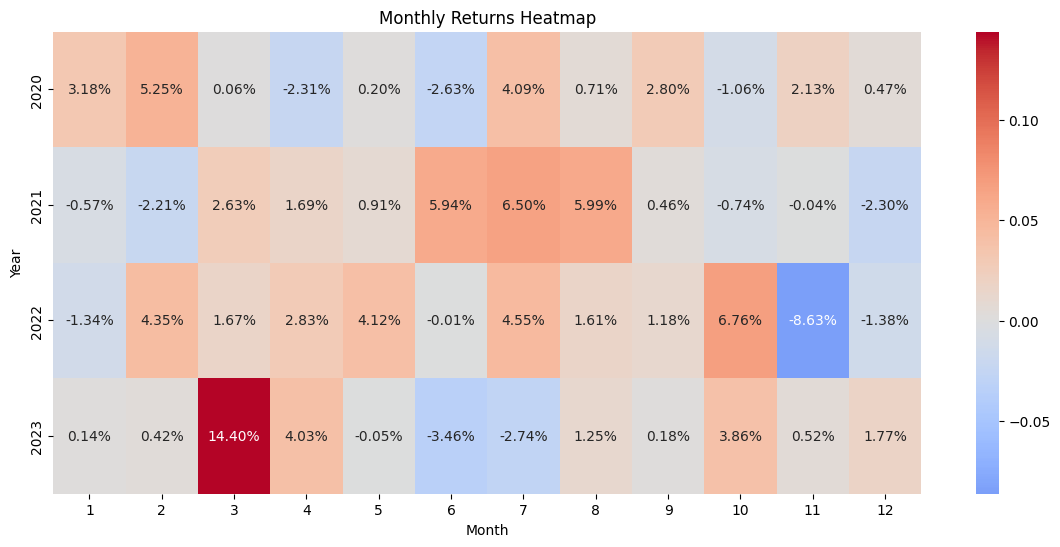

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 monthly_returns 是一个包含月度收益率的Series，并且它的索引是DateTimeIndex
# 如果它不是DataFrame，我们先将其转换成DataFrame
strategy_monthly_returns = strategy_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
benchmark_monthly_returns = benchmark_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
gap_monthly = strategy_monthly_returns - benchmark_monthly_returns

monthly_returns_df = gap_monthly.to_frame(name='收益率差')

# 创建新的列来代表年份和月份
monthly_returns_df['Year'] = monthly_returns_df.index.year
monthly_returns_df['Month'] = monthly_returns_df.index.month

# 使用pivot方法来创建适合热力图的DataFrame
pivot_table = monthly_returns_df.pivot(index='Year', columns='Month', values='收益率差')

# 使用Seaborn绘制热力图
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2%", cmap='coolwarm', center=0)
plt.title('Monthly Returns Heatmap')
plt.ylabel('Year')
plt.xlabel('Month')
plt.show()
